# The standalone NGCC plant baseline example and costing anaylsis

Natural gas combined cycle (NGCC) plants are a highly efficient and reliable way to generate electricity using natural gas as its primary fuel source. With the potential to achieve efficiency rates of up to 60%, these plants use two different types of turbines to generate electricity. The first turbine, called the gas turbine, burns natural gas to produce hot exhaust gases, which are then used to power a second turbine, called the steam turbine, that generates additional electricity. This process is known as a combined cycle, and it allows the plant to produce significantly more electricity than a traditional gas-fired power plant. The efficiency and cost performance of natural gas combined cycle plants have been extensively studied and validated by independent organizations such as the National Energy Technology Laboratory (NETL). In fact, the NETL report titled "Cost and Performance Baseline for Fossil Energy Plants, Volume 5b – Natural Gas Electricity Generating Units for Flexible Operation" specifically examines the cost and performance of natural gas electricity generating units for flexible operation, which includes combined cycle plants. This report provides valuable insights into the design and operation of these plants, which have been shown to be a cost-effective and efficient way to generate electricity using natural gas.

## 1. Import the NGCC process model

In [1]:
from ngcc_standalone_plant import get_ngcc_plant_model as build_ngcc_plant

## 2. Build the NGCC process simualtion

In [2]:
ngcc_plant_model = build_ngcc_plant()

Ipopt 3.13.2: tol=1e-07
linear_solver=ma27
max_iter=200
bound_push=1e-16


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes 

## 3. Display the Process Flowsheet Diagram of the NGCC process

A natural gas combined cycle plant generates electricity using a highly efficient process that involves two types of turbines. Natural gas enters the plant through a pipeline, where it is compressed and then burned in the combustion chamber of the gas turbine to create a high-temperature stream of hot gases. As the hot gases move through the gas turbine, they turn the blades of the turbine, which are connected to a generator to produce electricity. The exhaust gases from the gas turbine are routed through a heat recovery steam generator (HRSG), which uses the heat to produce steam. The steam powers a steam turbine, which is also connected to a generator to produce additional electricity. The electricity generated by both the gas turbine and steam turbine is combined and sent to the power grid to be distributed to homes and businesses. This combined cycle process allows for significantly higher efficiency compared to a simple gas-fired power plant, with some natural gas combined cycle plants achieving efficiency rates of up to 60%. The process also results in lower emissions of pollutants and greenhouse gases compared to traditional coal-fired power plants.

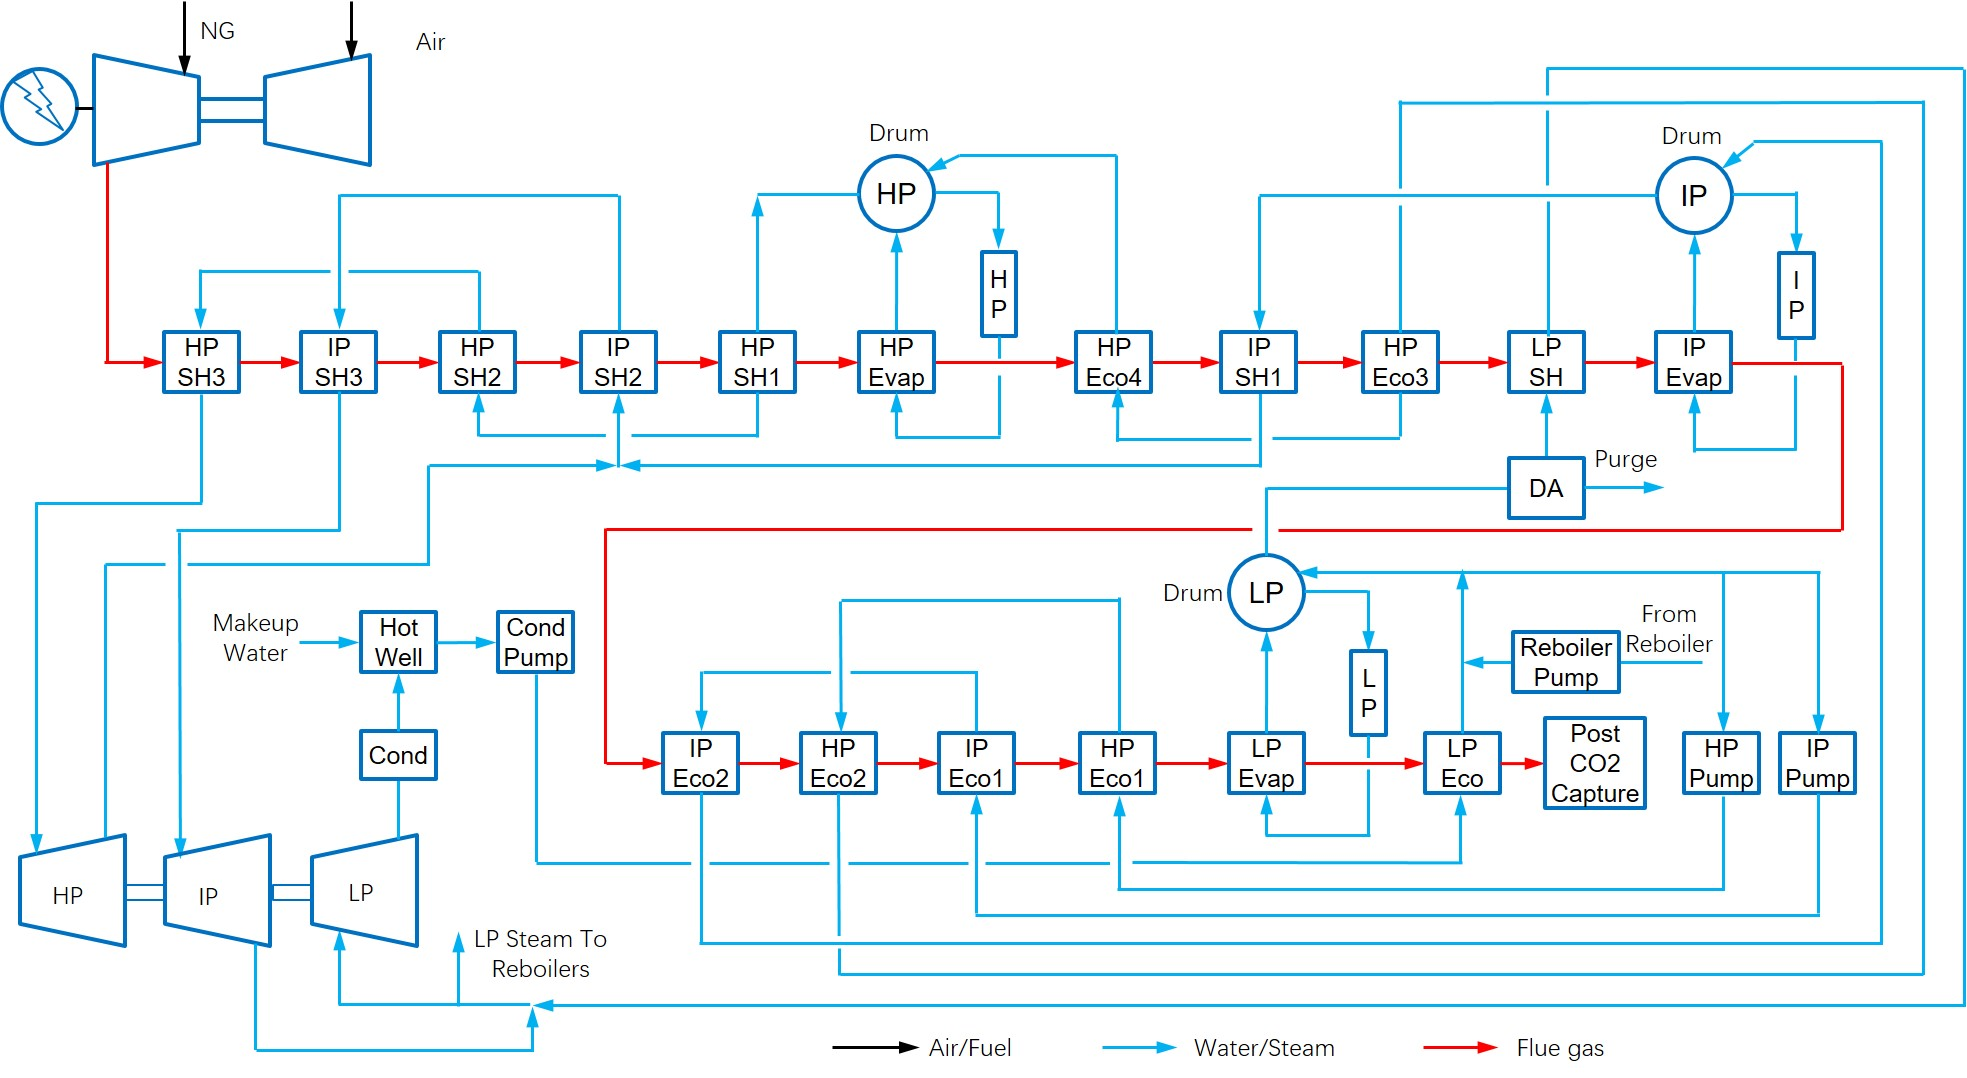

In [3]:
from IPython.display import display, Image
display(Image(filename = "ngcc_pfd.jpg"))

## 4.Display the results summary of process simulation

In [4]:
import pandas as pd
import pyomo.environ as pyo

m = ngcc_plant_model
res = pd.DataFrame(index = ['values'])
res['gas turbine net power(MW)'] = round(pyo.value(-m.fs.gt_net_power[0]/1e6),2)
res['steam turbine net power(MW)'] = round(pyo.value(m.fs.st_net_power[0]/1e6),2)
res['ng feed rate(kg/hr)'] = round(pyo.value(m.fs.gt_mix.fuel_inlet_state[0].flow_mol*16.5143*3.6),2)
res['flue gas flow rate(kg/hr)'] = round(pyo.value(m.fs.air_gas_mix3.mixed_state[0].flow_mol*m.fs.air_gas_mix3.mixed_state[0].mw),2)
res.T

,values
gas turbine net power(MW),270.05
steam turbine net power(MW),105.28
ng feed rate(kg/hr),51045.04
flue gas flow rate(kg/hr),536.16


In [5]:
import pytest
assert res.at['values','gas turbine net power(MW)'] == pytest.approx(270.05,rel = 1e-8)
assert res.at['values','ng feed rate(kg/hr)'] == pytest.approx(51045.04,rel = 1e-8)

## 5. Run the costing analysis of the NGCC process

In this work, a sophisticated bottom-up costing framework is built by implementing the methodology originally proposed by National Energy Technology Laboratory (NETL). The NETL costing methodology has been successfully applied in various applications from different types of power plants to hydrogen generation plants. Detailed information about NETL costing methodology is available in the 2019 revision of the Quality Guidelines for Energy System Studies (QGESS) document titled “Cost Estimation Methodology for NETL Assessment of Power Plant Performance.” (Theis, 2019) https://www.osti.gov/biblio/1567736

Import existing functions in the costing.py file and get them ready to use for the costing analysis later

In [6]:
from costing import *

The first step before start to doing the costing analysis is to set the background of the case, which includes the name of the plant and the assumed the capacity factor. In this example, we set the capacity of the NGCC plant as 100 %.

In [7]:
plant = Plant('ngcc', 1)

The second step is to prepare other data for the costing analysis in this case. The assumed power price and fuel price are stored in the price files. They are fixed for the costing analysis in this step. But we will demonstrate the way to release them as degrees of freedoms in the later section. 

In [8]:
case = plant.type
cf = plant.cf
for i in range(len(read_data(plant.files()[case]))):    
    product = pd.read_csv("reference/product.csv", header= 0, index_col = [0,1])
    if case is not None: 
        product[case] = read_data(plant.files()[case])[i]
    product.loc[['co2']] = product.loc[['co2']] /1000
    product.loc[['ng']] = product.loc[['ng']] * 49565.84/1e6
    product.reset_index(inplace = True)
    product.set_index('item',inplace = True,drop = True)
    price = pd.read_csv('reference/price.csv', header = 0, index_col = 0)
    total = pd.DataFrame()
    for col in product.drop('unit', axis = 1).columns:
        for index in price.instant.index:
            total.at[index,col] = product[col][index] * price.instant[index]*24*365/1e6

Based on the input information defined so far, the costing was completed and the levelized cost of electricity was used in this work as the key index.

In [9]:
cost= cost_cal(case)
summary = cost_sum(product,total,cost,case,cf)
LCOE = LCOE_cal(summary, product,cf,case)  

## 6. Summary of costing results using LCOE

The levelized cost of electricity (LCOE) is a financial metric used to compare the costs of producing electricity from different sources. It takes into account all of the costs involved in building and operating a power plant, including capital costs, operating and maintenance costs, fuel costs (if applicable), and financing costs. Capital costs refer to the upfront costs associated with building the power plant, while operating and maintenance costs are the ongoing costs associated with operating the power plant over its lifetime. If the power plant requires fuel, such as natural gas or coal-fired plants, the cost of fuel is factored into the LCOE calculation. Finally, financing costs refer to the cost of financing the construction and operation of the power plant, such as interest on loans or the cost of equity. By factoring in all of these components, the LCOE provides a comprehensive assessment of the total cost of producing electricity from a particular source, allowing for a more accurate comparison of different energy sources and informing investment and policy decisions related to energy production

In [10]:
import pandas as pd
lcoe = pd.read_csv('LCOE.csv', header = 0, index_col = 0) 
print(lcoe)

              Value, $/MWh
Capital               9.43
Fixed O&M             3.57
Variable O&M          1.56
Fuel                 28.53
Total                43.09


##  7. Plot the bar chart of LCOE

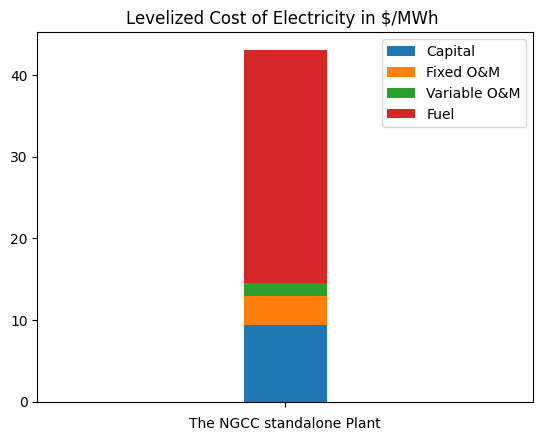

In [11]:
import matplotlib.pyplot as plt

df = pd.DataFrame()
df = lcoe.T.drop('Total', axis = 1)
df['The NGCC standalone Plant'] = ''

df.plot(x='The NGCC standalone Plant', kind='bar', stacked=True,
        title='Levelized Cost of Electricity in $/MWh ',
        width = 0.1)
plt.show()